In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## 1.Importing Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [3]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('../titanic/train.csv')
df_test = pd.read_csv('../titanic/test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## 2.Data Exploration

In [4]:
print(df_train.info())
#df_train.sample(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


**Basic Analysis on Variables:**
1. * 'PassengerId': the numerical order of passengers. H: no - There are no information given by ID.
2. * 'Pclass': Ordinal of social class. H: yes - the higher class is, 'Survived' more likely to be 1.
3. * 'Name': H:no.
4. * 'Sex': male and female. H:yes - female has 'Survived' are more likely to be 1.
5. * 'Age': H:yes - young ages are more likely to have 1.
6. * 'SibSp': H:yes - larger 'SibSp' are more likely to have 1.
7. * 'Parch': parent+childeren, H: ?.
8. * 'Ticket': H:no.
9. * 'Fare': Money paid. H: high 'Fare', high '1'
10. * 'Cabin': Cabin number. H: ?
11. * 'Embarked' place to board, C/Q/S. H: related.

In [5]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

Missing Data:
1. Training set: 
    Age(int), Cabin('B 32'), Embarked(C/Q/S)
2. Test set:
    Age(int), Cabin('B 32'), Fare(float)

Dealing Strategy:
1. Age: find highest correlation with other features -> fill the NaN with median of the group.
2. Cabin: Difficult to deal with here. Drop the column first. ????
3. Embarked: OneHotEncoder/ But here only 2 items missing, check their features and fill them.????
4. Fare: similar to embarked.

In [6]:
df_all_corr = df_all.corr().abs().sort_values(by=['Age'], ascending=False)#.abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000000,0.178740,0.150917,0.028814,0.408106,0.243699,0.077221
Pclass,0.408106,0.558629,0.018322,0.038354,1.000000,0.060832,0.338481
SibSp,0.243699,0.160238,0.373587,0.055224,0.060832,1.000000,0.035322
Fare,0.178740,1.000000,0.221539,0.031428,0.558629,0.160238,0.257307
Parch,0.150917,0.221539,1.000000,0.008942,0.018322,0.373587,0.081629
Survived,0.077221,0.257307,0.081629,0.005007,0.338481,0.035322,1.000000
PassengerId,0.028814,0.031428,0.008942,1.000000,0.038354,0.055224,0.005007


In [7]:
age_by_pclass = df_all.groupby(['Pclass'])['Age'].median()
for pclass in range(1,4):
    print('Median age of Pclass {} : {}'.format(pclass, age_by_pclass[pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

Median age of Pclass 1 : 39.0
Median age of Pclass 2 : 29.0
Median age of Pclass 3 : 24.0
Median age of all passengers: 28.0


In [8]:
df_all.info()
#df_all[df_all['Age'].isnull()]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [9]:
df_age_add = pd.DataFrame(list(df_all['Age'].isnull()), columns=['Age_missing'])
df_all_tmp = pd.concat([df_all,df_age_add],axis=1)


In [10]:
df_all = df_all_tmp
df_all.head(1)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing
0,22.0,NaN,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False


In [11]:
df_all['Age'] = df_all.groupby(['Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
### select grouped 'Age', then apply a function/method: fillna
### the function will be applied according to the group name: Pclass1, Pclass2, Pclass3 
df_all.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,False
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,False
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,False


In [12]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,False
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,False


In [13]:
df_all.groupby(['Pclass','Sex','Parch','SibSp'])['Embarked'].value_counts()[1]['female'][0][0]

Embarked
C    30
S    20
Name: Embarked, dtype: int64

In [14]:
df_all['Embarked'] = df_all['Embarked'].fillna('C')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Age_missing    1309 non-null bool
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 124.1+ KB


In [15]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,False


In [16]:
median_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp','Embarked'])['Fare'].median()[3][0][0]['S']
df_all['Fare'] = df_all['Fare'].fillna(median_fare)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Age_missing    1309 non-null bool
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 124.1+ KB


In [17]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = df_all.groupby(['Deck','Pclass']).count()
df_all_decks

Age  Cabin  Embarked  Fare  Name  Parch  PassengerId  Sex  SibSp  \
Deck Pclass                                                                     
A    1        22     22        22    22    22     22           22   22     22   
B    1        65     65        65    65    65     65           65   65     65   
C    1        94     94        94    94    94     94           94   94     94   
D    1        40     40        40    40    40     40           40   40     40   
     2         6      6         6     6     6      6            6    6      6   
E    1        34     34        34    34    34     34           34   34     34   
     2         4      4         4     4     4      4            4    4      4   
     3         3      3         3     3     3      3            3    3      3   
F    2        13     13        13    13    13     13           13   13     13   
     3         8      8         8     8     8      8            8    8      8   
G    3         5      5         5     5     5      5            5    5      5   
M    1        67      0        67    67    67     67           67   67     67   
     2       254      0       254   254   254    254          254  254    254   
     3       693      0       693   693   693    693          693  693    693   
T    1         1      1         1     1     1      1            1    1      1   

             Survived  Ticket  Age_missing  
Deck Pclass                                 
A    1             15      22           22  
B    1             47      65           65  
C    1             59      94           94  
D    1             29      40           40  
     2              4       6            6  
E    1             25      34           34  
     2              4       4            4  
     3              3       3            3  
F    2              8      13           13  
     3              5       8            8  
G    3              4       5            5  
M    1             40      67           67  
     2            168     254          254  
     3            479     693          693  
T    1              1       1            1

#### Create Deck feature

In [18]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = df_all.groupby(['Deck','Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages    
all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)

In [19]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'


In [20]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)

In [21]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

In [22]:
df_all.groupby(['Deck','Pclass']).count()

Age  Embarked  Fare  Name  Parch  PassengerId  Sex  SibSp  \
Deck Pclass                                                              
ABC  1       182       182   182   182    182          182  182    182   
DE   1        74        74    74    74     74           74   74     74   
     2        10        10    10    10     10           10   10     10   
     3         3         3     3     3      3            3    3      3   
FG   2        13        13    13    13     13           13   13     13   
     3        13        13    13    13     13           13   13     13   
M    1        67        67    67    67     67           67   67     67   
     2       254       254   254   254    254          254  254    254   
     3       693       693   693   693    693          693  693    693   

             Survived  Ticket  Age_missing  
Deck Pclass                                 
ABC  1            122     182          182  
DE   1             54      74           74  
     2              8      10           10  
     3              3       3            3  
FG   2              8      13           13  
     3              9      13           13  
M    1             40      67           67  
     2            168     254          254  
     3            479     693          693

In [23]:
df_all.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing,Deck
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False,M
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,False,ABC
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False,M
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,False,ABC
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,False,M


#### Create Family_Size = SibSp + Parch + 1

In [24]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] +1

family_map = {1: 'Alone', 2:'Small', 3:'Small', 4:'Small', 5:'Medium',6:'Medium', 7:'Large', 8:'Large', 9:'Large',10:'Large',11:'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)


In [25]:
#df_all['Family_Size_Grouped']=='Alone'

In [26]:
#df_all['Is_Alone'] = df_all[df_all['Family_Size_Grouped']==]

In [27]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

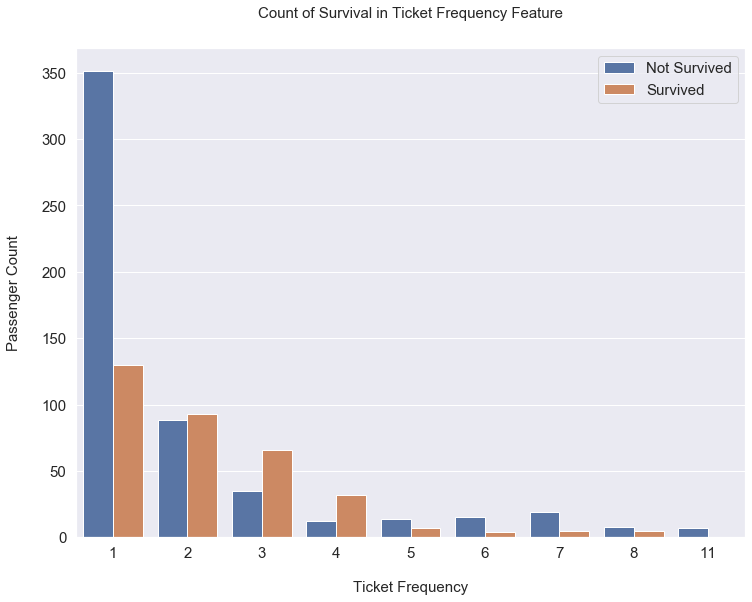

In [28]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

#### Fare qcut

In [29]:
df_all['Fare'] = pd.qcut(df_all['Fare'],13)

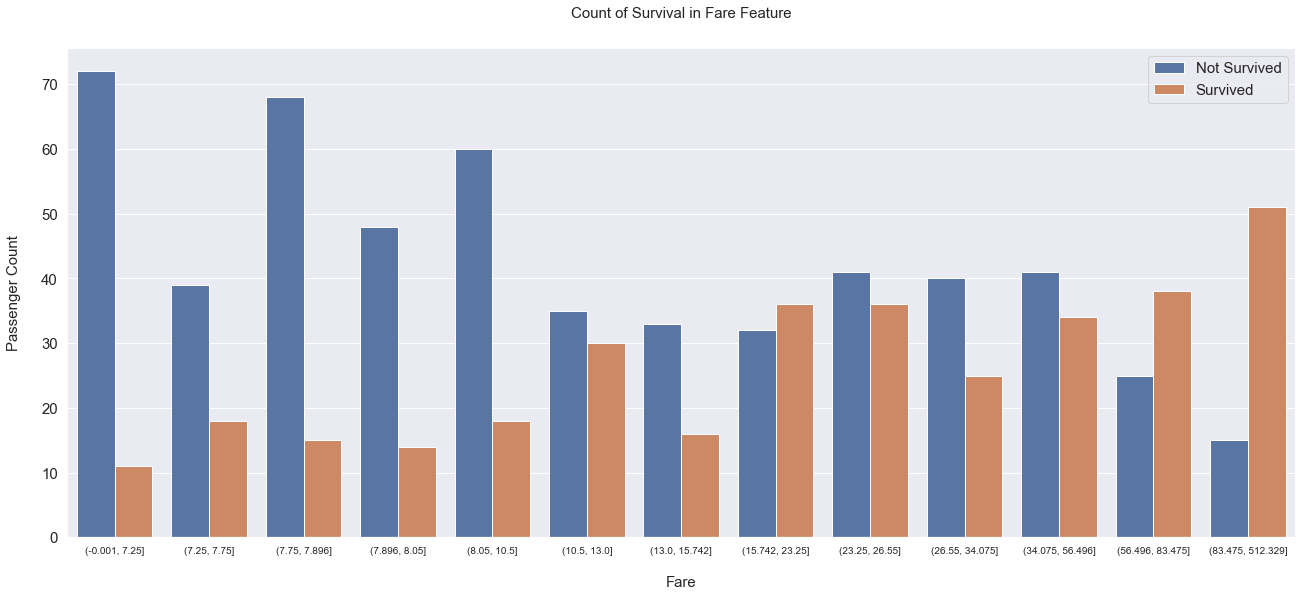

In [30]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

#### Age qcut

In [31]:
df_all['Age'] = pd.qcut(df_all['Age'],10,duplicates = 'drop')

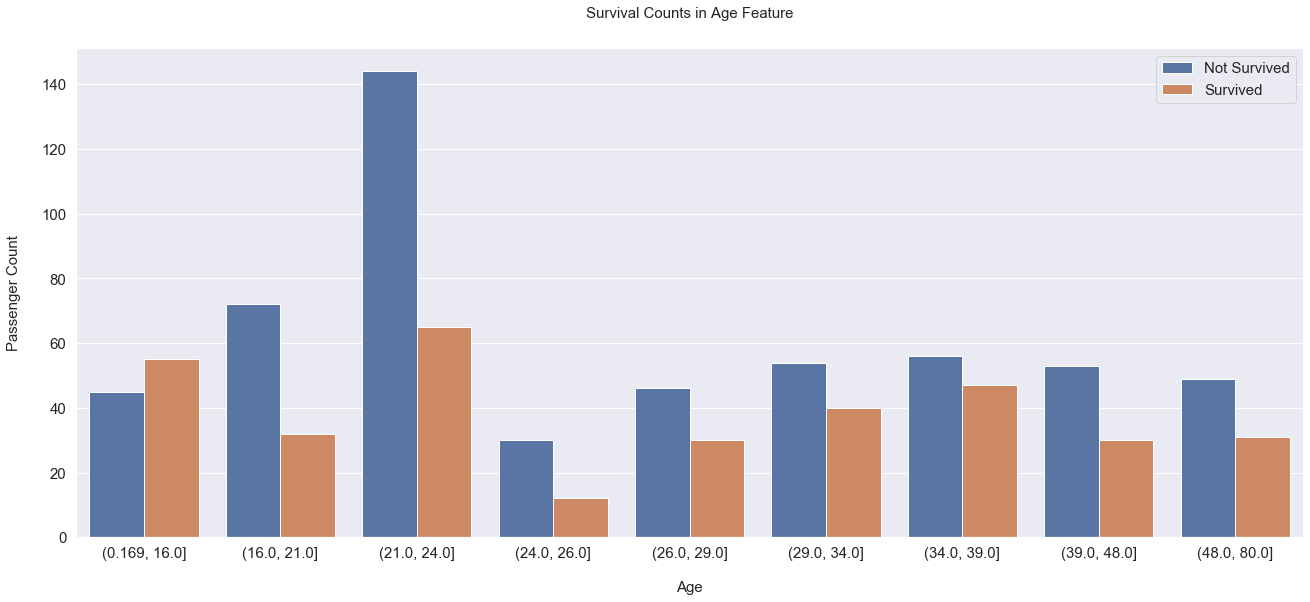

In [32]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

#### Title

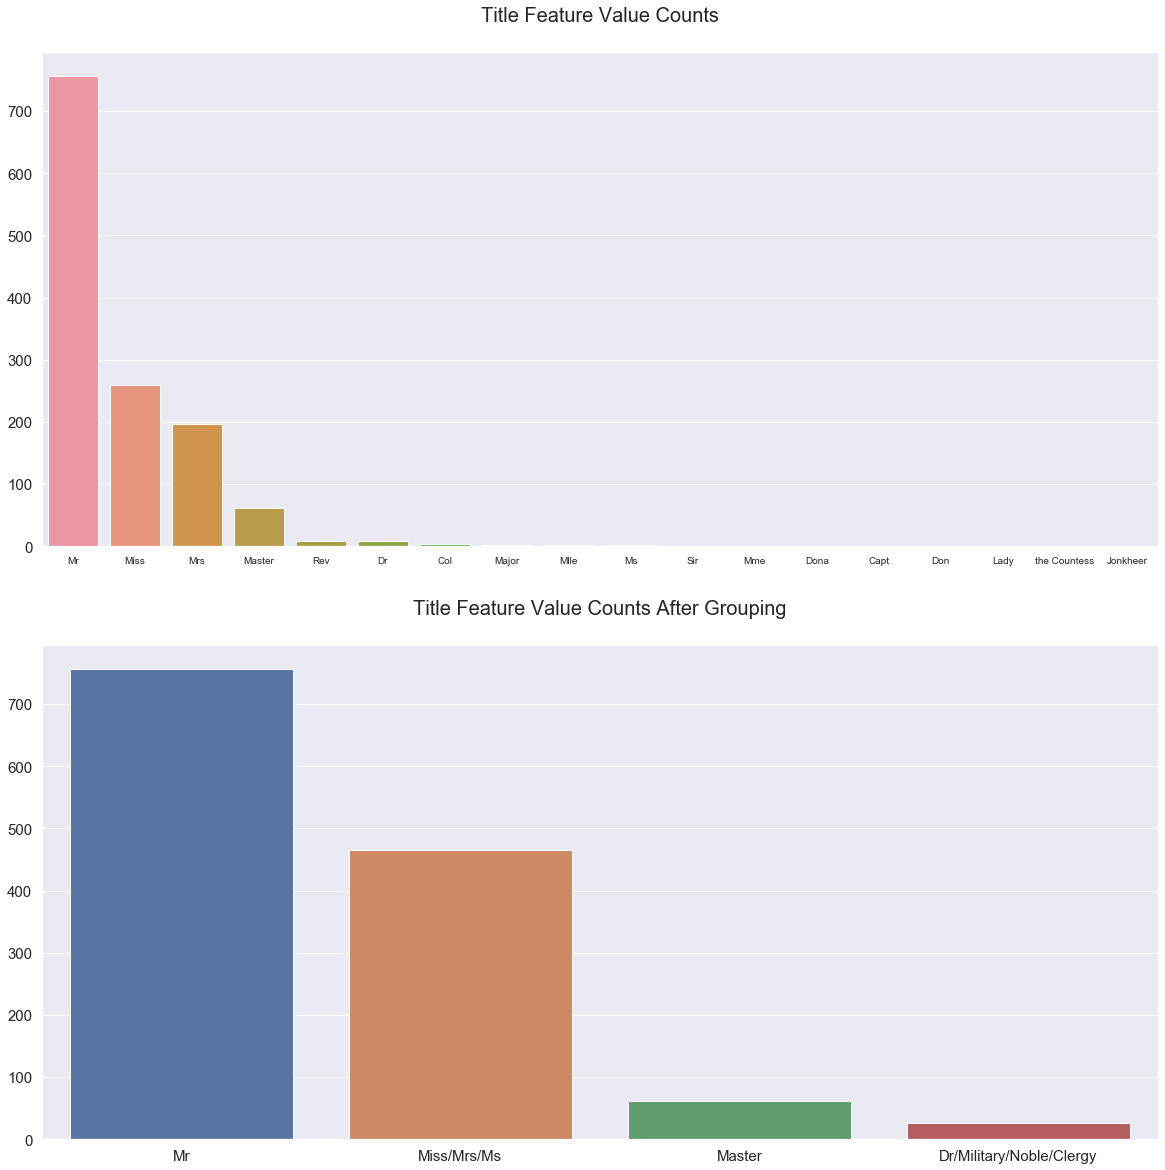

In [33]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

check the data

In [34]:
df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

df_all.head(3)


,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
0,"(21.0, 24.0]",S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False,M,2,Small,1,Mr,0
1,"(34.0, 39.0]",C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,False,ABC,2,Small,2,Miss/Mrs/Ms,1
2,"(24.0, 26.0]",S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False,M,1,Alone,1,Miss/Mrs/Ms,0


In [35]:
df_test.head(3)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Age_missing,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
891,"(34.0, 39.0]",Q,"(7.75, 7.896]","Kelly, Mr. James",0,892,3,male,0,330911,False,M,1,Alone,1,Mr,0
892,"(39.0, 48.0]",S,"(-0.001, 7.25]","Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,363272,False,M,2,Small,1,Miss/Mrs/Ms,1
893,"(48.0, 80.0]",Q,"(8.05, 10.5]","Myles, Mr. Thomas Francis",0,894,2,male,0,240276,False,M,1,Alone,1,Mr,0


## Correlations

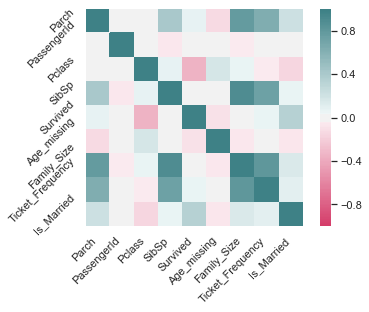

In [36]:
corr = df_train.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 200, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    verticalalignment='center'
);

### Categorical Features

In [37]:
df_all.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
0,"(21.0, 24.0]",S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False,M,2,Small,1,Mr,0
1,"(34.0, 39.0]",C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,False,ABC,2,Small,2,Miss/Mrs/Ms,1
2,"(24.0, 26.0]",S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False,M,1,Alone,1,Miss/Mrs/Ms,0
3,"(34.0, 39.0]",S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,False,ABC,2,Small,2,Miss/Mrs/Ms,1
4,"(34.0, 39.0]",S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,False,M,1,Alone,1,Mr,0


In [38]:
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]
#here dfs is a 2cols list, each col is a df.

### label encode

In [39]:
non_numeric_features = ['Embarked', 'Sex', 'Deck','Title', 'Age', 'Fare','Family_Size_Grouped']


for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [40]:
df_train.head(2)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
0,2,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,False,3,2,3,1,3,0
1,6,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,False,0,2,3,2,2,1


### onehot encode

In [41]:
cat_features = [ 'Embarked','Sex','Pclass', 'Deck','Title','Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [42]:
df_train.shape


(891, 38)

In [43]:
df_test.shape

(418, 38)

In [44]:
df_all = concat_df(df_train, df_test)
#df_all.head()
drop_cols = ['Embarked','PassengerId', 'Pclass', 'Sex','SibSp','Parch','Deck','Name','Ticket','Family_Size_Grouped',
             'Family_Size'
            ]

df_all.drop(columns=drop_cols, inplace=True)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 27 columns):
Age                      1309 non-null int32
Age_missing              1309 non-null bool
Deck_1                   1309 non-null float64
Deck_2                   1309 non-null float64
Deck_3                   1309 non-null float64
Deck_4                   1309 non-null float64
Embarked_1               1309 non-null float64
Embarked_2               1309 non-null float64
Embarked_3               1309 non-null float64
Family_Size_Grouped_1    1309 non-null float64
Family_Size_Grouped_2    1309 non-null float64
Family_Size_Grouped_3    1309 non-null float64
Family_Size_Grouped_4    1309 non-null float64
Fare                     1309 non-null int32
Is_Married               1309 non-null int64
Pclass_1                 1309 non-null float64
Pclass_2                 1309 non-null float64
Pclass_3                 1309 non-null float64
Sex_1                    1309 non-null float64
Sex_2    

In [45]:
df_all.head(1)

,Age,Age_missing,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,...,Pclass_3,Sex_1,Sex_2,Survived,Ticket_Frequency,Title,Title_1,Title_2,Title_3,Title_4
0,2,False,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1,3,0.0,0.0,0.0,1.0


Prepare for model and final

In [46]:
#columns_to_scale = ['']

In [47]:
X_model = df_all.loc[:890,df_all.columns != 'Survived']
y_model = df_all.loc[:890,'Survived']

X_final = df_all.loc[891:,df_all.columns != 'Survived']

Prepare for training set split: X_model ->  X_train, X_test

In [48]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, train_size = 0.7, random_state = 42)

Scaling

In [49]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler().fit(X_train)
# X_train_scaled = pd.DataFrame(sc.transform(X_train),
#                               index = X_train.index.values, 
#                               columns = X_train.columns.values
#                              )
# X_test_scaled  = pd.DataFrame(sc.transform(X_test),
#                               index = X_test.index.values,
#                               columns = X_test.columns.values
#                               )
# X_model_scaled = pd.DataFrame(sc.transform(X_model),
#                               index = X_model.index.values,
#                               columns = X_model.columns.values
#                               )
# X_final_scaled = pd.DataFrame(sc.transform(X_final),
#                        index = X_final.index.values,
#                        columns = X_final.columns.values
#                        )

In [50]:
X_model.head()

,Age,Age_missing,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,...,Pclass_2,Pclass_3,Sex_1,Sex_2,Ticket_Frequency,Title,Title_1,Title_2,Title_3,Title_4
0,2,False,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1,3,0.0,0.0,0.0,1.0
1,6,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2,2,0.0,0.0,1.0,0.0
2,3,False,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0
3,6,False,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,2,2,0.0,0.0,1.0,0.0
4,6,False,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1,3,0.0,0.0,0.0,1.0


# Train and Predict

### now we have
'X_train_scaled', 'y_train':  to  train the model<br>
'X_test_scaled', 'y_test: to get scores of models       <br>        # Will train error high and test error low happen? 

### Try different model (now without Hyperparameter tuning (CV), later add it)

In [57]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, test_size=.20) # need to learn

In [58]:
All_models = {} # {model1: model1_score, model2:model2_score}

#### 1. Random Forest

In [60]:
n_estimators = [100,150,200,500,600];
max_depth = range(7,11);
min_samples_leaf = [6,7,8,9]
#max_features = ['sqrt']
#criterions = ['gini', 'entropy'];

parameters = {'n_estimators':n_estimators,
              'min_samples_leaf': min_samples_leaf,
              'max_depth':max_depth,
             # 'max_features': max_features
            #  'criterion': criterions
              }
RF = GridSearchCV(estimator=RandomForestClassifier(bootstrap = True, max_features='sqrt'),
                           param_grid=parameters,
                           cv=cv,
                           n_jobs = -1
                          )

RF.fit(X_model,y_model) 
print("The best CV score is:\n{:0.4f}".format(RF.best_score_))


The best CV score is:
0.8413


In [61]:
RF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
All_models.update({RF.best_estimator_ : RF.best_score_})

#### 2. KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = range(2,31)
weights=['uniform','distance']
parameters = {'n_neighbors':n_neighbors, 
              'weights':weights
             }
KNN = GridSearchCV(KNeighborsClassifier(), 
                           parameters,
                           cv=cv,
                           verbose = False, 
                           n_jobs=-1
                          )
KNN.fit(X_model,y_model) 
print("The best CV score is:\n{:0.4f}".format(KNN.best_score_))

The best CV score is:
0.8179


In [64]:
KNN.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                     weights='uniform')

In [65]:
All_models.update({KNN.best_estimator_: KNN.best_score_})

#### 3. Bagging Classifier

In [66]:
from sklearn.ensemble import BaggingClassifier
n_estimators = [80,150,160, 170,175,180,500,1000]
max_features = [4,5,6,7,8]
parameters = {'n_estimators':n_estimators,
              'max_features':max_features,
              }
BG = GridSearchCV(BaggingClassifier(),
                  param_grid=parameters,
                  cv=cv,
                  n_jobs = -1
                 )
BG.fit(X_model,y_model) 
print("The best CV score is:\n{:0.4f}".format(BG.best_score_))



The best CV score is:
0.8469


In [67]:
BG.best_estimator_

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=8, max_samples=1.0, n_estimators=500,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [68]:
All_models.update({BG.best_estimator_ : BG.best_score_})

#### 4. SVM

In [69]:
from sklearn.svm import SVC
Cs = [0.001, 0.01, 0.1, 1,1.4,1.5,1.7,2,2.5,3,4,5, 10] ## penalty parameter C for the error term. 
gammas = [0.0001,0.001, 0.01, 0.1, 0.2, 0.4, 1]
kernels = ['rbf','poly']
param_grid = {'C': Cs, 'gamma' : gammas}
SVM = GridSearchCV(SVC(probability=True), 
                   param_grid, 
                   cv=cv
                  )
SVM.fit(X_model, y_model)
print("The best CV score is:\n{:0.4f}".format(SVM.best_score_))

The best CV score is:
0.8458


In [70]:
SVM.best_estimator_

SVC(C=1.4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [71]:
All_models.update({SVM.best_estimator_ : SVM.best_score_})

#### 5. AdaBoost

In [72]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [50,100,150,180,300,600,1000]
learning_r = [.01, .05, .1, .15, .2, .4, .5, .6, .9, 1]
parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              }
ADB = GridSearchCV(AdaBoostClassifier(),
                   param_grid=parameters,
                   cv=cv,
                   n_jobs = -1
                  )
ADB.fit(X_model, y_model)
print("The best CV score is:\n{:0.4f}".format(ADB.best_score_))

The best CV score is:
0.8335


In [73]:
ADB.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.05,
                   n_estimators=300, random_state=None)

In [74]:
All_models.update({ADB.best_estimator_ : ADB.best_score_})

#### 6.Extra Trees 

In [75]:
from sklearn.ensemble import ExtraTreesClassifier
EXT = ExtraTreesClassifier()

In [76]:
from sklearn.model_selection import cross_val_score

EXT_score = np.mean(cross_val_score(EXT, X_model, y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(EXT_score))
EXT.fit(X_model, y_model)                                        

The CV score is:
0.8179


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [131]:
#All_models.pop(EXT)

0.8178770949720671

In [132]:
All_models.update({EXT : EXT_score+0.0001})

#### 7. Gaussian Naive Bayesian

In [79]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

GNB = GaussianNB()
GNB_score = np.mean(cross_val_score(GNB, X_model, y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(GNB_score))
GNB.fit(X_model, y_model)                                    
# gaussian.fit(X, y)
# y_pred = gaussian.predict(X_test)
# gaussian_accy = round(accuracy_score(y_pred, y_test), 3)
#print(gaussian_accy)

The CV score is:
0.8089


GaussianNB(priors=None, var_smoothing=1e-09)

In [80]:
All_models.update({GNB: GNB_score})

#### 8. Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier
max_depth = range(1,30)
max_feature = [21,22,23,24,25,26,'auto']
criterion=["entropy", "gini"]

param = {'max_depth':max_depth, 
         'max_features':max_feature, 
         'criterion': criterion}
DT = GridSearchCV(DecisionTreeClassifier(), 
                                param_grid = param, 
                                 verbose=False, 
                                 cv=cv,#StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                n_jobs = -1)
DT.fit(X_model, y_model) 
print("The best CV score is:\n{:0.4f}".format(DT.best_score_))

The best CV score is:
0.8380


In [82]:
DT.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=21, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [83]:
All_models.update({DT.best_estimator_ : DT.best_score_})

#### 9. Gradient Boost Classifier

In [84]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier()
GB_score = np.mean(cross_val_score(GB, X_model, y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(GB_score))
GB.fit(X_model, y_model)    

The CV score is:
0.8581


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [85]:
All_models.update({GB: GB_score})

#### 10. XGB

In [86]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB_score = np.mean(cross_val_score(XGB, X_model, y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(XGB_score))
XGB.fit(X_model, y_model)    

The CV score is:
0.8313


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [87]:
All_models.update({XGB: XGB_score})

#### 11.Gaussian Process Classifier 

In [88]:
from sklearn.gaussian_process import GaussianProcessClassifier
GPC = GaussianProcessClassifier()
GPC_score = np.mean(cross_val_score(GPC, X_model, y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(GPC_score))
GPC.fit(X_model, y_model)    

The CV score is:
0.8056


GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False)

In [89]:
All_models.update({GPC: GPC_score})

#### 12. vote

In [139]:
from sklearn.ensemble import VotingClassifier
VOT = VotingClassifier(estimators=[('RF',RF.best_estimator_),
                                   ('BG',BG.best_estimator_),
                                   ('KNN',KNN.best_estimator_),
                                   ('SVM',SVM.best_estimator_),
                                   ('ADB',ADB.best_estimator_),
                                   ('EXT',EXT),
                                   ('GNB',GNB),
                                   ('DT',DT.best_estimator_),
                                   ('GB',GB),
                                   ('XGB',XGB),
                                   ('GPC',GPC)
                                 ],
                       voting='hard'
                      )
VOT_score = np.mean(cross_val_score(VOT, X_model, y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(VOT_score))
VOT.fit(X_model, y_model)           

The CV score is:
0.8425


VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=10,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=7,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=150,
                                                     n_jobs=None,
            

In [162]:
#All_models.pop(VOT)
All_models.update({VOT : VOT_score})

### Compare all the models using test set

#### Get every model's test score:

In [163]:
All_models_zip = zip(All_models.values(), All_models.keys())
All_models_sorted = sorted(All_models_zip, reverse=True)
All_models_sorted

[(0.8581005586592179,
  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                             learning_rate=0.1, loss='deviance', max_depth=3,
                             max_features=None, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators=100,
                             n_iter_no_change=None, presort='auto',
                             random_state=None, subsample=1.0, tol=0.0001,
                             validation_fraction=0.1, verbose=0,
                             warm_start=False)),
 (0.846927374301676,
  BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                    max_features=8, max_samples=1.0, n_estimators=500,
                    n_jobs=None, oob_score=False, random_state=None, verbose=0,
                    warm_

#### Find the best model:

In [164]:
model_Best = All_models_sorted[3][1]

In [165]:
#model_Best = RF.best_estimator_
model_Best

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=10,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=7,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=150,
                                                     n_jobs=None,
            

In [147]:
#X_final.head()

### Use the best model to predict the final target

In [166]:
y_final_predict = model_Best.predict(X_final)

In [167]:
PassengerId = pd.Series(range(892,1310))
#PassengerId

In [168]:

result_df = pd.DataFrame(columns=['PassengerId','Survived'])
result_df['PassengerId'] = PassengerId
result_df['Survived'] = y_final_predict
result_df = result_df.astype(int)
result_df.to_csv('submissions.csv', index=False)
result_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
